In [1]:
import pandas as pd
import numpy as np

import yaml

import sklearn
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords

import scipy

import gensim
from gensim.models import CoherenceModel
import gensim.corpora as corpora

import bertopic
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

import matplotlib.pyplot as plt

import pickle

import import_ipynb
from parse_1 import txt_file_to_list, record_file

import warnings
warnings.filterwarnings("ignore")

importing Jupyter notebook from parse_1.ipynb


# Построение nlp моделей

В этом ноутбуке провожу анализ комментариев с помощью моделей nlp тематического моделирования. Выбираю наилучшую и улучшаю ее.

In [2]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

In [3]:
file_comments_preprocessed = config['preprocessing']['comments_preprocessed']

In [4]:
comments = txt_file_to_list(file_comments_preprocessed)

# 1. Векторизация

Векторизуем наши комментарии для подачи на вход моделей.

In [5]:
rs = config['nlp_modeling']['random_state']
test_size = config['nlp_modeling']['test_size']

In [6]:
def split_train_test(df, random_state: int, test_size: float):
    """
    Разделение на трейн и тест
    :params df: массив типа данных список, кортеж, нампай массив, датафрейм и тд.
    :params random_state: рандом стейт
    :params test_size: размер тестовой выборки
    :return: результат разбиения на трейн/тест
    """
    return train_test_split(df, random_state=random_state, test_size=test_size)


In [7]:
train, test = split_train_test(comments, rs, test_size)

In [8]:
test_comments_path = config['nlp_modeling']['test_comments']

In [14]:
# Сохраню тестовые комментарии для ноутбука evaluate
record_file(test_comments_path, test)

In [8]:
min_df = config['nlp_modeling']['min_df']
ngram_range = config['nlp_modeling']['ngram_range']

In [9]:
def tf_vectorizer_fit_predict(df: list[str],
                              min_df: int,
                              ngram_range: list[int],
                              stopwords: list[str] = stopwords.words('russian')
                              ) -> (sklearn.feature_extraction, scipy.sparse):
    """
    tf-idf векторизация списка строк.
    :params df: список строк
    :params min_df: минимальная частота встречаемого термина
    :params ngram_range: список с n-граммами (с какого по какое n)
    :return: модель векторайзера
    :return: сжатая матрица с векторизованными строками
    """
    vectorizer = TfidfVectorizer(min_df=min_df, ngram_range=tuple(ngram_range),
                                 stop_words=stopwords)
    transform = vectorizer.fit_transform(df)
    return vectorizer, transform


In [10]:
vectorizer, vectorizer_comments = tf_vectorizer_fit_predict(train, min_df, 
                                                            ngram_range)

# 2. Обучение бейзлайнов

## 2.1 NMF baseline

Обучим бейзлайн nmf и посмотрим на оценку когерентности на трейне

In [12]:
def nmf_baseline(data, random_state: int) -> sklearn.decomposition._nmf.NMF:
    """
    Обучение бейзлайна NMF
    :params data: матрица эмбеддингов
    :params random_state: рандом стейт
    :return: объект модели NMF
    """
    nmf = NMF(random_state=random_state)
    nmf.fit(data)
    return nmf


In [31]:
%%timeit
nmf_baseline(vectorizer_comments, rs)

10min 11s ± 10.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
nmf_base = nmf_baseline(vectorizer_comments, rs)

In [11]:
def get_coherence_mean(texts: list[str], model=None, n_top_words: int = 20,
                       topics: np.ndarray = None) -> float:
    """
    Расчет средней оценки когерентности модели на данных
    :params texts: список со строками
    :params model: объект модели
    :params n_top_words: количество топ-слов в каждой тематике
    :params topics: матрица компонентов после преобразования nmf или lda
    :return: значение когерентности
    """
    if topics is None:
        topics = model.components_
    texts = [[word for word in doc.split()] for doc in texts]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    feature_names = [dictionary[i] for i in range(len(dictionary))]

    top_words = []
    for topic in topics:
        top_words.append(
            [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

    coherence_model = CoherenceModel(topics=top_words,
                                     corpus=corpus,
                                     texts=texts,
                                     dictionary=dictionary,
                                     coherence='c_v')

    coherence = coherence_model.get_coherence()
    return coherence


In [98]:
get_coherence_mean(train, model=nmf_base)

0.5461337154932578

## 2.2 LDA baseline

Обучим бейзлайн lda и посмотрим на оценку когерентности на трейне

In [14]:
def lda_baseline(
    data, random_state: int
) -> sklearn.decomposition._lda.LatentDirichletAllocation:
    """
    Обучение бейзлайна LDA
    :params data: матрица эмбеддингов
    :params random_state: рандом стейт
    :return: объект модели LDA
    """
    lda = LatentDirichletAllocation(learning_method='online',
                                    random_state=random_state, n_jobs=-1)
    lda.fit(data)
    return lda


In [28]:
%%timeit
lda_baseline(vectorizer_comments, rs)

41.8 s ± 1.66 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
lda_base = lda_baseline(vectorizer_comments, rs)

In [103]:
get_coherence_mean(train, model=lda_base)

0.58721518935545

## 2.3. LDA bagging baseline

Создам бэггинг из LDA

In [45]:
def lda_bagging_base(
        data: scipy.sparse._csr.csr_matrix, 
        n_estimators: int, bagging_fraction: float, random_state: int
    ) -> np.ndarray:
    """
    Бэггинг из бейзлайнов lda
    :params data: сжатая матрица эмбеддингов
    :params n_estimators: количество моделей в бэггинге
    :params random_state: рандом стейт
    :return: усредненная матрица компонентов от моделей lda
    """
    np.random.seed(random_state)
    data = scipy.sparse.lil_matrix(data).toarray()
    # Список, в котором будут храниться компоненты со всех эстиматоров
    sum_components = []

    for i in range(n_estimators):
        # Генерируем бутстрэп из исходных данных
        idx = np.random.randint(data.shape[0], 
                                size=int(data.shape[0] * bagging_fraction))
        sample = data[idx, :]

        # Обучаем LDA на сгенерированном сэмпле
        lda = LatentDirichletAllocation(learning_method='online',
                                        random_state=random_state, n_jobs=-1)
        lda.fit(sample)
        sum_components.append(lda.components_)

    topics_mean = np.mean(np.array(sum_components), axis=0)
    return topics_mean


In [60]:
n_estimators = config['nlp_modeling']['n_estimators']
bagging_fraction = config['nlp_modeling']['bagging_fraction']

In [62]:
topics_lda_bagging = lda_bagging_base(vectorizer_comments, 
                                      n_estimators, bagging_fraction, rs)

In [64]:
get_coherence_mean(train, topics=topics_lda_bagging)

0.6213113304203361

LDA обучается намного быстрее, чем NMF

## 2.4. BERTopic baseline

Обучим  бейзлайн модели bertopic и посмотрим на оценку когерентности на трейне

In [12]:
language = config['nlp_modeling']['language']

In [43]:
def bertopic_baseline(
    data: list[str], random_state: int, language: str
) -> (bertopic._bertopic.BERTopic, list[int], np.ndarray):
    """
    Обучение бейзлайна bertopic
    :params data: список со строками
    :params random_state: рандом стейт
    :params language: язык, на котором написаны документы в data
    :return: объект модели bertopic
    :return: список с метками топиков к каждому документу из data
    :return: массив вероятностей каждого документа в data к каждому топику
    """
    umap_model = UMAP(random_state=random_state)
    topic_model = BERTopic(language=language, umap_model=umap_model,
                           calculate_probabilities=True)

    topics, probs = topic_model.fit_transform(data)
    return topic_model, topics, probs


In [44]:
bertopic_baseline, topics_baseline, probs_baseline = bertopic_baseline(train, 
                                                                       rs,
                                                                       language)

In [13]:
def get_coherence_mean_bertopic(
    topic_model: bertopic._bertopic.BERTopic,
    topics: list[int], data: list[str]
) -> float:
    """
    Расчет средней оценки когерентности модели bertopic на данных
    :params topic_model: объект модели bertopic
    :params topics: список с метками топиков к каждому документу из data
    :params data: список со строками
    :return: среднее значение когерентности
    """
    # Создаем таблицу для удобной аггрегации текстов по топикам
    documents = pd.DataFrame({"Document": data,
                              "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'],
                                            as_index=False).agg({'Document':
                                                                 ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.
                                                Document.values)

    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)]
                   for topic in range(len(set(topics))-1)]

    coherence_model = CoherenceModel(topics=topic_words,
                                     texts=tokens,
                                     corpus=corpus,
                                     dictionary=dictionary,
                                     coherence='c_v')

    coherence = coherence_model.get_coherence()
    return coherence


In [46]:
get_coherence_mean_bertopic(bertopic_baseline, topics_baseline, train)

0.7115334750741957

Когерентность выше всего у bertopic.

# 3. Тюнинг модели bertopic

Попытаемся улучшить модель bertopic

In [14]:
umap_params = config['nlp_modeling']['umap_params']
hdbscan_params = config['nlp_modeling']['hdbscan_params']
n_gram_range_bert = config['nlp_modeling']['n_gram_range_bert']

In [15]:
def bertopic_tuning(data: list[str], umap_params: list[dict],
                    hdbscan_params: list[dict], language: str, 
                    min_df: int, n_gram_range: list[int], random_state: int
    ) -> (list[int], bertopic._bertopic.BERTopic, list[int], np.ndarray):
    """
    Тюнинг модели Bertopic при помощи сетки параметров. Выбор наилучшей модели
    при помощи оценки средней когерентности.
    :params data: список с документами
    :params umap_params: сетка параметров для UMAP
    :params hdbscan_params: сетка параметров для HDBSCAN
    :params language: язык, на котором написаны документы в data
    :params min_df: минимальная частота встречаемого термина
    :params ngram_range: список с n-граммами (с какого по какое n)
    :params random_state: рандом стейт
    :return: список оценок когерентности на каждой итерации
    :return: объект модели bertopic
    :return: список с метками топиков к каждому документу из data
    :return: эмбеддинги документа data
    """
    coherence_best = 0
    coherence_list = []

    for umap_param in umap_params:
        for hdbscan_param in hdbscan_params:
            umap_model = UMAP(**umap_param, random_state=random_state)
            hdbscan_model = HDBSCAN(**hdbscan_param, gen_min_span_tree=True,
                                    prediction_data=True)
            vectorizer_model = CountVectorizer(min_df=min_df,
                                       ngram_range=tuple(n_gram_range))

            model = BERTopic(
                umap_model=umap_model,
                hdbscan_model=hdbscan_model,
                vectorizer_model=vectorizer_model,
                language=language,
                calculate_probabilities=True
            )
            topics, _ = model.fit_transform(data)

            coherence = get_coherence_mean_bertopic(model, topics, data)
            coherence_list.append(coherence)

            if coherence > coherence_best:
                coherence_best = coherence
                model_best, topics_best = model, topics

    print(f'best coherense = {coherence_best}')
    embeddings = model_best.embedding_model.embed(data)
    return coherence_list, model_best, topics_best, embeddings


In [19]:
coh_list, bertopic_tuned, topics_tuned, embeddings = bertopic_tuning(train,
                                                                     umap_params,
                                                                     hdbscan_params,
                                                                     language, 
                                                                     min_df,
                                                                     n_gram_range_bert,
                                                                     rs)


best coherense = 0.7111865609216431


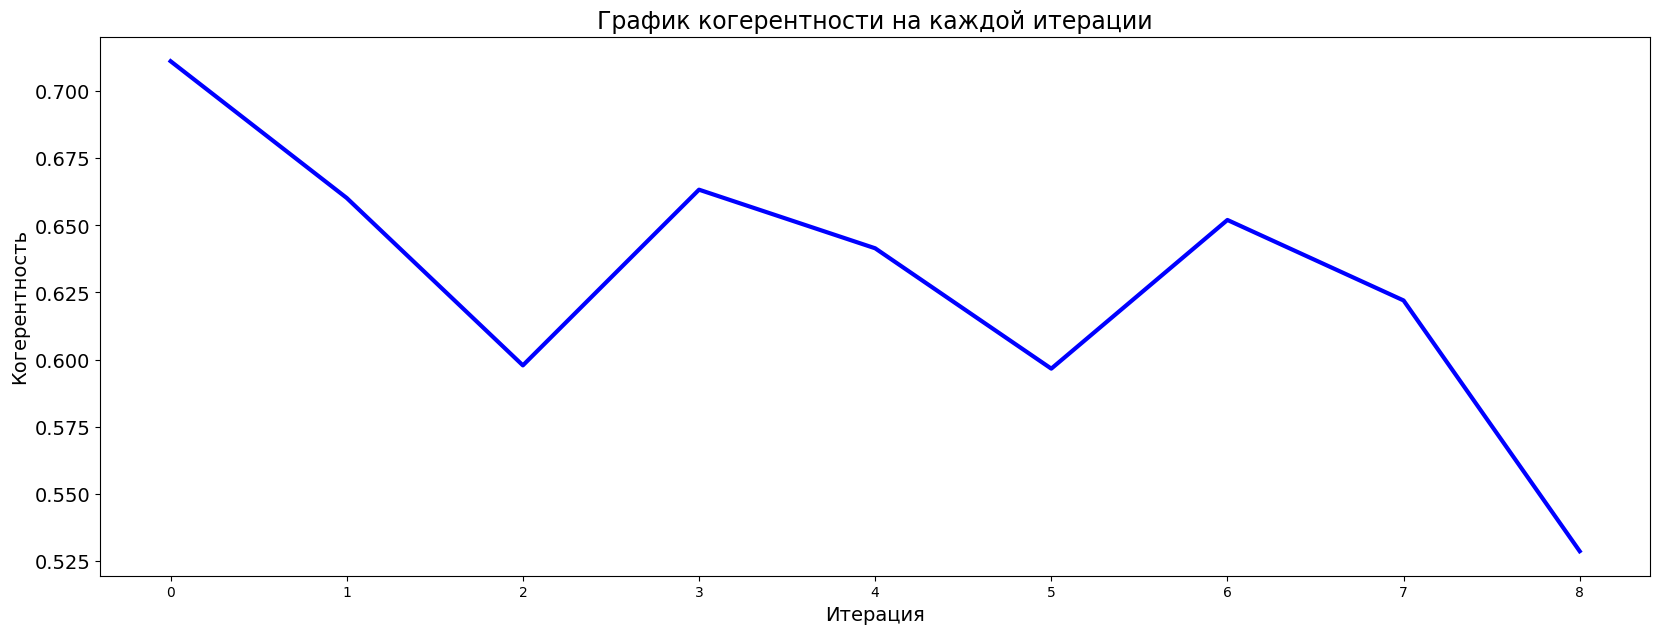

In [21]:
fig = plt.figure(figsize=(20,7))

plt.plot(
    range(len(coh_list)),
    coh_list,
    linewidth=3,
    color='blue'
)

plt.yticks(fontsize=14)
plt.xlabel('Итерация', fontsize=14)
plt.ylabel('Когерентность', fontsize=14)
plt.title('График когерентности на каждой итерации', fontsize=17)

plt.show()

In [22]:
bertopic_tuned.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,9354,-1_играть_это_хороший_спасибо,"[играть, это, хороший, спасибо, год, барабанщи...",[отличаться хороший барабанщик плохой хороший ...
1,0,10050,0_это_такой_правило_просто,"[это, такой, правило, просто, очень, последний...","[это неправда, имб это элемент восемьдесят пиж..."
2,1,3263,1_барабан_барабанщик_играть_барабанный,"[барабан, барабанщик, играть, барабанный, это,...","[будущее барабан хобби, кавказок барабан играт..."
3,2,1352,2_видео_ролик_спасибо_очень,"[видео, ролик, спасибо, очень, ваш, полезный, ...","[вдохновлять видео, долгожданный видео, слайд ..."
4,3,893,3_спасибо_спасибо очень_очень_большой,"[спасибо, спасибо очень, очень, большой, благо...","[зарешать спасибо, спасибо заметка, спасибо по..."
5,4,849,4_играть_игра_ритм_сыграть,"[играть, игра, ритм, сыграть, уметь, уметь игр...","[охрененно играть, офигенно играть, нлрмальный..."
6,5,737,5_звук_звучать_слушать_слышать,"[звук, звучать, слушать, слышать, слух, голос,...","[выключить звук, звук шум, звук дюйм]"
7,6,453,6_нога_рука_упражнение_левый,"[нога, рука, упражнение, левый, палец, правый,...",[хотеться урок комбинировать техника нога кара...
8,7,397,7_песня_разбор_разобрать_пожалуйста,"[песня, разбор, разобрать, пожалуйста, сделать...","[песня нащываться, типичный песня алкоголик, в..."
9,8,380,8_учитель_класс_ученик_урок,"[учитель, класс, ученик, урок, препод, школа, ...","[учитель псих раздолбать, ван хален горячий уч..."


Когерентность хоть и получилась немного ниже, чем в бейзлайне, но по субъективной оценке топики интерпретируемы лучше, да и их количество оказалось меньше.

In [23]:
bertopic_tuned.visualize_topics()

In [29]:
bertopic_tuned.visualize_barchart()

In [30]:
bertopic_tuned.visualize_hierarchy()

In [40]:
def features_target_table(features: np.ndarray, target: list) -> pd.DataFrame:
    """
    Конкатенация таблицы признаков с вектором таргетов
    :params features: таблица признаков
    :params target: вектор таргетов
    :return: датафрейм с признаками и таргетом
    """
    df = pd.DataFrame(features)
    df['target'] = target
    return df

In [41]:
train_df = features_target_table(embeddings, topics_tuned)

# 4. Постобработка получившихся результатов

## 4.1. Сохранение моделей и данных

In [50]:
def df_to_csv(data: pd.DataFrame, path: str) -> None:
    """
    Сохранение таблицы по заданному пути
    :params data: таблица, которую надо сохранить
    :params path: путь до файла
    """
    data.to_csv(path, index=False)

In [55]:
train_df_path = config['nlp_modeling']['train_df']

In [59]:
df_to_csv(train_df, train_df_path)

In [68]:
def to_pickle(data, path: str) -> None:
    """
    Сохранение данных по заданному пути в формат pickle
    :params data: данные, которые надо сохранить
    :params path: путь до файла
    """
    with open(path, 'wb') as f:
        pickle.dump(data, f)

In [64]:
bertopic_model_path = config['nlp_modeling']['bertopic_model']

In [69]:
# Сохраню модель бертопика
to_pickle(bertopic_tuned, bertopic_model_path)

In [ ]:
embed_model_path = config['nlp_modeling']['embed_model']

In [ ]:
#Сохраню модель эмбеддингов из бертопика отдельно
to_pickle(bertopic_tuned.embedding_model, embed_model_path)

## 4.2. Обработка названий топиков

Ниже поработаю над презентацией топиков. Вручную изучу всю информацию с топиков и напишу каждому из них описание.

In [5]:
topics_info = bertopic_tuned.get_topic_info()[['Topic', 'Representative_Docs']]

In [6]:
# Заменю мусорные топики с -1 на 30, чтобы не было отрицательного класса.
topics_info['Topic'] = topics_info['Topic'].replace(-1, 30)

In [45]:
# список с пояснением топиков
topics_list = ("Мусор",
               "Осознание и изменение ложных убеждений и привычек",
               "Барабаны как хобби",
               "Долгожданное вдохновляющее видео",
               "Благодарность за тренирующее видео",
               "Восхищение игрой на барабанах",
               "Шумное и громкое видео",
               "Синхронизация движений ног и рук в уроке",
               "Песня об алкоголизме",
               "Учитель и ученик в музыке",
               "Панк-рок",
               "Настройка и использование метронома",
               "Эволюция музыкальных предпочтений",
               "Оценка мастерства гитаристов",
               "Употребление алкоголя",
               "Реакция на соседа",
               "Хороший/плохой барабанщик",
               "Выразительный бас",
               "Стереотипы о русской культуре и водке",
               "Благодарность за урок",
               "Металл и джаз: разнообразие барабанной музыки",
               "Разнообразие рок-музыки",
               "Оценка канала",
               "Метал и его эволюция",
               "Поиск хорошего барабанного контента на русском YouTube",
               "Оценка хорошего и плохого барабанщика, независимо от цвета",
               "Оценка звучания тарелок в песне",
               "Огонь в драмбассе и фильме Бьорна Гелотта",
               "Оценка барабанщика по цвету его футболки",
               "Соединение барабанщика и гитариста",
               "Концерт и впечатления от Вайнберга")

In [48]:
topics_info['Representation'] = topics_list

In [49]:
topics_info

,Topic,Representative_Docs,Representation
0,30,[отличаться хороший барабанщик плохой хороший ...,Мусор
1,0,"[это неправда, имб это элемент восемьдесят пиж...",Осознание и изменение ложных убеждений и привычек
2,1,"[будущее барабан хобби, кавказок барабан играт...",Барабаны как хобби
3,2,"[вдохновлять видео, долгожданный видео, слайд ...",Долгожданное вдохновляющее видео
4,3,"[зарешать спасибо, спасибо заметка, спасибо по...",Благодарность за тренирующее видео
5,4,"[охрененно играть, офигенно играть, нлрмальный...",Восхищение игрой на барабанах
6,5,"[выключить звук, звук шум, звук дюйм]",Шумное и громкое видео
7,6,[хотеться урок комбинировать техника нога кара...,Синхронизация движений ног и рук в уроке
8,7,"[песня нащываться, типичный песня алкоголик, в...",Песня об алкоголизме
9,8,"[учитель псих раздолбать, ван хален горячий уч...",Учитель и ученик в музыке


In [52]:
topics_info_path = config['nlp_modeling']['topics_info']

In [53]:
df_to_csv(topics_info, topics_info_path)